In [1]:
pacman::p_load(tidyverse, readxl, vcfR, VariantAnnotation, rtracklayer, Biostrings, Rsamtools,plyranges)


data_vaf = read_csv("../../data/annotated-calls_vaf.csv") %>% 
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data = read_csv("../../data/annotated-calls.csv") %>%
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data$AF = data_vaf$`VAF[reads, BSMN]`[match(data$var_id, data_vaf$var_id)]
data = data %>% filter(AF < 0.40, Dx != "ASD")



cov_info = read_tsv("../../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]
data = data %>% filter(Dataset == "Chess")


## filter outlier
data = data %>% filter(`Individual ID` != "CMC_MSSM_224") 

make_vcf <- function(data){
    c <- paste0("chr",data$CHROM)
    s <- data$POS 
    e <- as.integer(s+sapply(as.character(data$REF),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$REF)
    alt(v) <- DNAStringSetList(lapply(data$ALT, function(x){x}))
    mcols(v)$subject = data$`Individual ID`
    mcols(v)$VAF = data$AF
    return(v)
}

v_all = make_vcf(data)
v_scz = make_vcf(data %>% filter(Dx=="SCZ"))
v_ctrl = make_vcf(data %>% filter(Dx!= "SCZ"))



Rows: 3383 Columns: 28
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (15): POS, VAF[alleles, BSMN], BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCN...
num  (2): FORMAT/AD, FORMAT/PL

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 6426 Columns: 137
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Reg

In [2]:
library(biomaRt)
#ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")

listMarts(host="https://grch37.ensembl.org")
mart <- useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", GRCh=37, mirror="useast")
att <- listAttributes(mart)

# transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
#                                   "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
#       filters ="ensembl_gene_id",
#       values  =gene_names$ensembl_gene_id,
#       mart    =mart)


transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
                                  "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
      mart    =mart)

library(regioneR)
transcripts.gr <- toGRanges(transcripts)

#Filter out non-standard chromosomes
transcripts.gr <- keepSeqlevels(transcripts.gr, c(1:22,"X", "Y"), pruning.mode = "coarse")
colnames(mcols(transcripts.gr)) <- c("STRAND","ensembl_gene_id","transcription_start_site","hgnc_symbol")
## get the longest transcript
rd = splitAsList(transcripts.gr, transcripts.gr$ensembl_gene_id)
maxwd = which.max(width(rd))
refgene.longest = rd[splitAsList(unname(maxwd), names(maxwd))]

transcript.gr = unlist(refgene.longest)
seqlevelsStyle(transcript.gr) <- "UCSC"


biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 111
ENSEMBL_MART_SNP,Ensembl Variation 111
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 111


Warning message:
“version or GRCh arguments cannot be used together with the mirror argument.
We will ignore the mirror argument and connect to the main Ensembl site.”


In [3]:
## Get all the TF sites
library(plyranges)
tf_files = system("ls ../../resources/hg19_cistrome/*.A.bed",intern = TRUE)
length(tf_files)

tf = lapply(tf_files, function(x){
    tmp = rtracklayer::import(x,format="BED")
    tf_name = gsub(pattern = "../resources/hg19_cistrome/|_HUMAN.A.bed",replacement = "",x = x)
    tmp$tf_name = tf_name
    #tmp = keepSeqlevels(tmp, c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "fine")
    seqlevelsStyle(tmp) <- "UCSC"
    return(tmp)
})

tf = keepSeqlevels(GRangesList(tf), c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "tidy")
tf_final = do.call("c",tf)
tf_final = tf_final[!duplicated(tf_final)]

[1] 138

In [4]:
library(plyranges)
ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)
total_length = sum(seqlengths(BSgenome.Hsapiens.UCSC.hg19)[1:24])
total_length

## adapted from https://github.com/Rashesh7/PanBody_manuscript_analyses/blob/main/Signature_Enrichment/Testes_analyses_Signature_and_Enrichment_analyses.Rmd

library(MutationalPatterns)

## Get target vcfs
scz_vcf = granges(v_scz)
ctrl_vcf  = granges(v_ctrl)
genome(ctrl_vcf) = "hg19"
genome(scz_vcf) = "hg19"
target_vcf = scz_vcf

get_triRate <- function(target_vcf, ref_genome = "BSgenome.Hsapiens.UCSC.hg19", surveyed=NULL){
    ## Compute 96 trinuc context and total muts per sample
    muts0 = mut_matrix(target_vcf, ref_genome)

    muts <- as_tibble(muts0) %>% 
          mutate(mutType = rownames(muts0)) %>% 
          rowwise() %>%
          mutate(totMuts = sum(c_across(where(is.numeric)))) %>% 
          mutate(context = paste0(str_sub(mutType,1,1),str_sub(mutType,3,3),str_sub(mutType,7,7))) %>% 
          group_by(context) %>% 
          dplyr::summarise(count = sum(totMuts), .groups = "drop")

    ## Get mean sites per tissue
    if(is.null(surveyed)){
        sequences  = getSeq(BSgenome.Hsapiens.UCSC.hg19)[1:24]
    } else{
        sequences = getSeq(BSgenome.Hsapiens.UCSC.hg19,surveyed)
    }

    ## count trinuc freq
    tri_freqs <- trinucleotideFrequency(sequences)

    #Convert to pyr reference
    complement = vector()
    complement["A"] = "T"; complement["C"] = "G"; complement["G"] = "C"; complement["T"] = "A";
    tri_freqs_summary <- as_tibble(tri_freqs) %>% 
        dplyr::summarise(across(.cols = everything(), sum)) %>% 
        pivot_longer(cols = everything(), names_to = "context0", values_to = "count") %>% 
        mutate(context = ifelse(str_sub(context0,2,2) %in% c("C", "T"), context0, paste0(complement[str_sub(context0, 3,3)], complement[str_sub(context0, 2,2)], complement[str_sub(context0, 1,1)]))) %>% 
        group_by(context) %>% 
        dplyr::summarise(count = sum(count), .groups = "drop")
        colnames(tri_freqs_summary) <- c("context", paste0("opps_", "WGS"))
        muts <- muts %>% 
        left_join(tri_freqs_summary, by = "context")

    ## Generate triRateDF
    triRateDF <- tibble()
    freqDF <- muts %>% 
          rowwise() %>%
          mutate(meanOpps = mean(c_across(cols = starts_with("opps_")))) %>% 
          mutate(rate = count/meanOpps) %>% 
#           mutate(rate = rate/sum(lengths(target_vcf))) %>% 
          dplyr::select(context, rate)
    triRateDF <- triRateDF %>% bind_rows(freqDF)
    return(triRateDF)
}

Loading required package: BSgenome



[1] 3095677412

Loading required package: NMF

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')


Attaching package: ‘NMF’


The following object is masked from ‘package:S4Vectors’:

    nrun




In [5]:
## Enrichment functoin of CpG sites
oe_func2 <- function(target_vcf,region,regionName, triRateTable, b,
                    surveyed=NULL,ref_genome = "BSgenome.Hsapiens.UCSC.hg19",cpg=FALSE){

    
    ## calculate observed and expected ratio
    n_muts = length(target_vcf)
    
    if(is.null(surveyed)){
        library(ref_genome, character.only = TRUE)
        gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19)[1:24]
        surveyed_length = sum(letterFrequency(gwide.seq,letters = c(b[1],b[3])))
    } else{
        gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19,surveyed)
        surveyed_length = sum(letterFrequency(gwide.seq,letters = c(b[1],b[3])))
    }

    if(is.null(surveyed)){
        surveyed_region = region
    } else{
        surveyed_region = surveyed %>% join_overlap_intersect(region)
    }
    
    reg_seqs = getSeq(BSgenome.Hsapiens.UCSC.hg19, surveyed_region)
    surveyed_region_length = sum(dinucleotideFrequency(reg_seqs)[,c("CG")])
    

    # Find which mutations lie in the surveyed genomic region
    extension = 1
    dinuc_context <- as.character(Biostrings::getSeq(
    BSgenome::getBSgenome(ref_genome),
    seqnames(target_vcf),
    start(target_vcf) - extension,
    end(target_vcf) + extension
    ))

    target_vcf$dn = dinuc_context
    plus_cg = c("ACG","CCG","GCG","TCG")
    neg_cg = c("CGA","CGC","CGG","CGT")
    
#     target_vcf = target_vcf %>% filter(!(dn %in% plus_cg | dn %in% neg_cg))
    
    target_vcf = target_vcf[ (target_vcf$REF == b[1] & as.character(unlist(target_vcf$ALT)) == b[2] & target_vcf$dn %in% plus_cg) | 
                  (target_vcf$REF == b[3] & as.character(unlist(target_vcf$ALT)) == b[4] & target_vcf$dn %in% neg_cg)]
    
    triRateTable = get_triRate(target_vcf = target_vcf)
    
    
    muts_in_region = target_vcf %>% filter_by_overlaps(surveyed_region)
    observed = sum(countOverlaps(surveyed_region, target_vcf))

    #Add base to start and end to get correct trinuc counts
    surveyed_region@ranges@start <- as.integer(surveyed_region@ranges@start - 1)
    surveyed_region@ranges@width <- as.integer(surveyed_region@ranges@width + 2)
    
    #Count trinuc freq
    sequences = getSeq(BSgenome.Hsapiens.UCSC.hg19, surveyed_region)
    tri_freqs <- trinucleotideFrequency(sequences)

    complement = vector()
    complement["A"] = "T"; complement["C"] = "G"; complement["G"] = "C"; complement["T"] = "A";	
    tri_freqs_summary <- as_tibble(tri_freqs) %>% 
        dplyr::summarise(across(.cols = everything(), sum)) %>% 
        pivot_longer(cols = everything(), names_to = "context0", values_to = "count") %>% 
        #Convert to pyr reference
        mutate(context = ifelse(str_sub(context0,2,2) %in% c("C", "T"), context0, paste0(complement[str_sub(context0, 3,3)], complement[str_sub(context0, 2,2)], complement[str_sub(context0, 1,1)]))) %>% 
        group_by(context) %>% 
        dplyr::summarise(count = sum(count), .groups = "drop") %>% 
        left_join((triRateTable), by = "context") %>% 
        mutate(expected = count * (rate))
    
    if(cpg){
        tri_freqs_summary = tri_freqs_summary %>% filter(substr(context,2,3) == "CG")
    } else{
        tri_freqs_summary = tri_freqs_summary %>% filter(substr(context,2,3) != "CG") %>%
            filter(substr(context,2,2) == b[1])
    }

    expected = sum(tri_freqs_summary$expected)
    
    ## calculate CIs
#     n_sims = 10000
#     observations = replicate(n_sims, 
#                              sum(countOverlaps(target_vcf[sort(sample(length(target_vcf), size=length(target_vcf), 
#                                                                       replace=TRUE))],surveyed_region)))
#     cis <- quantile(observations, probs = c(0.025, 0.975))
    
    tmp = poisson.test(c(observed,surveyed_region_length),c(expected, surveyed_region_length))
#     pval = sum(observations/expected <1)/n_sims
    pval = tmp$p.value
    cis = tmp$conf.int
    
    res = data.frame(n_muts,
                surveyed_length,
                regionName,
                surveyed_region_length,
                expected,
                observed,
                     oe = observed/expected,
                    low_ci= cis[1],
                    high_ci = cis[2], pval = pval)
    return(res)

}


In [6]:
scz_tritable = get_triRate(target_vcf = scz_vcf)

In [7]:
distance_tf = c("5000","2000","1000","500","100")
df = as.data.frame(transcript.gr)
tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                              end=df$transcription_start_site),strand=df$STRAND)

tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)
dhs = rtracklayer::import("../../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
dhs$ntile = ntile(dhs$score,20)
dhs = dhs[dhs$ntile==20]

base_list = list(c("C","A","G","T"),
                c("C","G","G","C"),
                c("C","T","G","A"))

library(parallel)
get_base_change_ratios2 <- function(b){
    dist_from_tss = c(5000,2000,1000,500,100)
    stats_df = mclapply(dist_from_tss, function(x){
#         region = resize(tfbs_dhs_promoter, width=2*as.numeric(x), fix="center")
        region = resize(tf_final %>% reduce_ranges(), width=2*as.numeric(x), fix="center")
        region = region %>% filter_by_overlaps(dhs) %>% filter_by_overlaps(tss.gr) #%>% reduce_ranges()
        res= oe_func2(scz_vcf, region=region, regionName="TFBS+DHS+promoter",
                      triRateTable = scz_tritable,b = b,cpg = TRUE)
        res$base_change = paste0(b[1],">",b[2])
        return(res)
    })
    
    stats_df = do.call(rbind,stats_df)
    stats_df = stats_df %>% mutate(dists = dist_from_tss)
    
    return(stats_df)
}

base_df = lapply(base_list, function(x){get_base_change_ratios2(x)})

full_stat = do.call(rbind, base_df)
full_stat = full_stat %>% mutate(base_change = factor(base_change, levels=c("C>A","C>G","C>T","T>A","T>C","T>G"))) %>%
    mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100,50)))

options(repr.plot.width=8, repr.plot.height=4)
p1=full_stat %>% ggplot(aes(x=dists, y=oe)) + 
    geom_pointrange(aes(color=base_change,ymin=low_ci, ymax= high_ci), size=1, show.legend = FALSE) +
    geom_line(aes(group=base_change, color=base_change), show.legend = FALSE) +
    theme_classic(16) + geom_hline(yintercept = 1,linetype=2, size=1) +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1)) +
        labs(x="Binned distance to TFBS + DHS + promoter\nat CpG sites",color="Base Change", y="observed/expected") +
    facet_wrap(.~base_change, nrow=1,ncol=6) +
    scale_color_manual(values = c(
  "#2EBAED", "#000000", "#DE1C14",
  "#D4D2D2", "#ADCC54", "#F0D0CE")) +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
full_stat




library(parallel)
get_base_change_ratios2 <- function(b){
    dist_from_tss = c(5000,2000,1000,500,100)
    stats_df = mclapply(dist_from_tss, function(x){
#         region = resize(tfbs_dhs, width=2*as.numeric(x), fix="center")
        region = resize(tf_final %>% reduce_ranges(), width=2*as.numeric(x), fix="center")
        region = region %>% filter_by_overlaps(dhs) # %>% reduce_ranges()
        res= oe_func2(scz_vcf, region=region, regionName="TFBS+DHS",
                      triRateTable = scz_tritable,b = b,cpg = TRUE)
        res$base_change = paste0(b[1],">",b[2])
        return(res)
    })
    
    stats_df = do.call(rbind,stats_df)
    stats_df = stats_df %>% mutate(dists = dist_from_tss)
    
    return(stats_df)
}

base_df = lapply(base_list, function(x){get_base_change_ratios2(x)})

full_stat = do.call(rbind, base_df)
full_stat = full_stat %>% mutate(base_change = factor(base_change, levels=c("C>A","C>G","C>T","T>A","T>C","T>G"))) %>%
    mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100,50)))

options(repr.plot.width=8, repr.plot.height=4)
p2=full_stat %>% ggplot(aes(x=dists, y=oe)) + 
    geom_pointrange(aes(color=base_change,ymin=low_ci, ymax= high_ci), size=1, show.legend = FALSE) +
    geom_line(aes(group=base_change, color=base_change), show.legend = FALSE) +
    theme_classic(16) + geom_hline(yintercept = 1,linetype=2, size=1) +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1)) +
        labs(x="Distance to TFBS + DHS\nat CpG sites",color="Base Change", y="observed/expected") +
    facet_wrap(.~base_change, nrow=1,ncol=6) +
    scale_color_manual(values = c(
  "#2EBAED", "#000000", "#DE1C14",
  "#D4D2D2", "#ADCC54", "#F0D0CE")) +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
full_stat

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


n_muts,surveyed_length,regionName,surveyed_region_length,expected,observed,oe,low_ci,high_ci,pval,base_change,dists
<int>,<int>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
2236,1170371008,TFBS+DHS+promoter,5214894,2.92926665,0,0.0000000,0.000000000,1.2593189,1.303915e-01,C>A,5000
2236,1170371008,TFBS+DHS+promoter,1290656,0.71109362,0,0.0000000,0.000000000,5.1876218,1.000000e+00,C>A,2000
2236,1170371008,TFBS+DHS+promoter,591143,0.31963599,0,0.0000000,0.000000000,11.5409124,1.000000e+00,C>A,1000
2236,1170371008,TFBS+DHS+promoter,311924,0.16531061,0,0.0000000,0.000000000,22.3149700,1.000000e+00,C>A,500
2236,1170371008,TFBS+DHS+promoter,47262,0.02482087,0,0.0000000,0.000000000,148.6258693,1.000000e+00,C>A,100
2236,1170371008,TFBS+DHS+promoter,5214894,5.01230677,18,3.5911609,2.128347834,5.6755881,5.596954e-06,C>G,5000
2236,1170371008,TFBS+DHS+promoter,1290656,1.26251291,6,4.7524267,1.744053581,10.3440604,1.931003e-03,C>G,2000
2236,1170371008,TFBS+DHS+promoter,591143,0.58893421,2,3.3959651,0.411266163,12.2674476,1.182716e-01,C>G,1000
2236,1170371008,TFBS+DHS+promoter,311924,0.31656339,2,6.3178500,0.765117569,22.8224378,4.068795e-02,C>G,500


n_muts,surveyed_length,regionName,surveyed_region_length,expected,observed,oe,low_ci,high_ci,pval,base_change,dists
<int>,<int>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
2236,1170371008,TFBS+DHS,7242174,4.14541822,0,0.0000000,0.0000000,0.8898693,4.185152e-02,C>A,5000
2236,1170371008,TFBS+DHS,1837906,1.03460571,0,0.0000000,0.0000000,3.5654966,6.323357e-01,C>A,2000
2236,1170371008,TFBS+DHS,806850,0.44548905,0,0.0000000,0.0000000,8.2805354,1.000000e+00,C>A,1000
2236,1170371008,TFBS+DHS,427452,0.23041288,0,0.0000000,0.0000000,16.0099355,1.000000e+00,C>A,500
2236,1170371008,TFBS+DHS,88833,0.04735847,0,0.0000000,0.0000000,77.8943321,1.000000e+00,C>A,100
2236,1170371008,TFBS+DHS,7242174,6.81861403,19,2.7864900,1.6776480,4.3514526,9.331679e-05,C>G,5000
2236,1170371008,TFBS+DHS,1837906,1.75853987,6,3.4119215,1.2521134,7.4263310,9.338215e-03,C>G,2000
2236,1170371008,TFBS+DHS,806850,0.78727684,2,2.5404024,0.3076540,9.1768368,1.866422e-01,C>G,1000
2236,1170371008,TFBS+DHS,427452,0.42696877,2,4.6841833,0.5672745,16.9209842,6.892617e-02,C>G,500


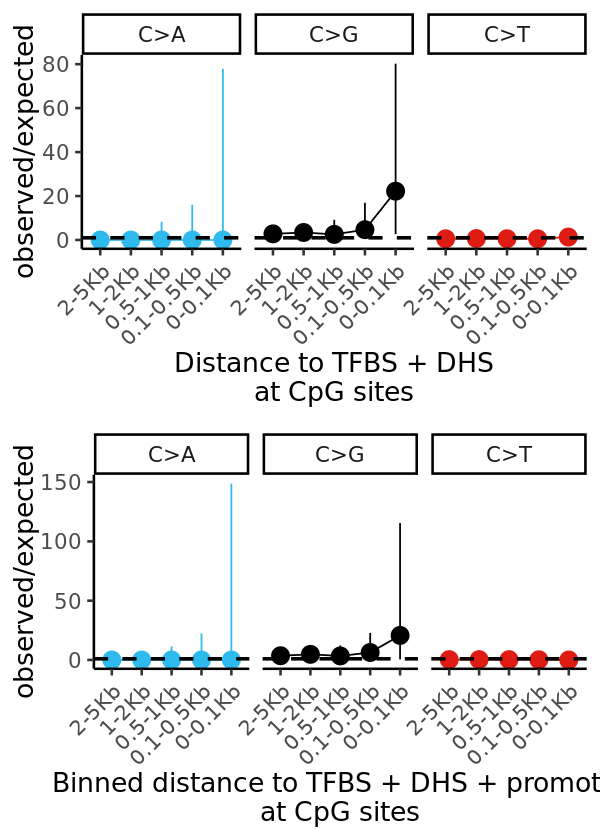

In [8]:
options(repr.plot.width=5, repr.plot.height=7)
p3 = ggpubr::ggarrange(p2,p1, ncol=1, nrow=2)
p3
ggsave(p3, filename  ="../../figures//cpg_rpg_tfbs_no_outlier.pdf", width=5, height=7)

In [9]:
## All other dataset

## Rodin et al dataset
asd_calls = readxl::read_xlsx("../../data//rodin_data.xlsx",sheet=4,skip = 1)
make_vcf_asd <- function(data){
    c <- paste0("chr",data$Chromosome)
    s <- data$Position
    e <- as.integer(s+sapply(as.character(data$Ref),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$Ref)
    alt(v) <- DNAStringSetList(lapply(data$Alt, function(x){x}))
    mcols(v)$subject = data$`Case ID`
    mcols(v)$VAF = data$VAF
    return(v)
}

# path = system.file(package="liftOver", "extdata", "hg38ToHg19.over.chain")
# ch = import.chain(path)

# to_hg19 <- function(v, ch){
#     v0 = liftOver(v, ch)
#     v0 = unlist(v0)
#     genome(v0) = "hg19"
#     return(v0)
# }


v_all_asd = make_vcf_asd(asd_calls)
v_asd = make_vcf_asd(asd_calls %>% filter(Diagnosis=="ASD"))
v_asd_ctrl = make_vcf_asd(asd_calls %>% filter(Diagnosis!= "ASD"))


## Jonsson et al

twin_mosaic = read_tsv("../../resources/Jonsson_etal_mosaic_variants.tsv") %>% filter(nchar(Ref) == 1 & nchar(Alt) == 1)
nrow(twin_mosaic)
make_vcf_twin <- function(data){
    c <- paste0(data$Chr)
    s <- data$Pos
    e <- as.integer(s+sapply(as.character(data$Ref),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$Ref)
    alt(v) <- DNAStringSetList(lapply(data$Alt, function(x){x}))
    mcols(v)$subject = data$ProbandEnum
    mcols(v)$VAF = data$Proband_AB
    return(v)
}

pacman::p_load(liftOver)
path = system.file(package="liftOver", "extdata", "hg38ToHg19.over.chain")
ch = import.chain(path)

to_hg19 <- function(v, ch){
    v0 = liftOver(v, ch)
    v0 = unlist(v0)
    genome(v0) = "hg19"
    return(v0)
}


v_twin = to_hg19(make_vcf_twin(twin_mosaic), ch)


v_control_combined = granges(v_ctrl) %>% bind_ranges(granges(v_asd_ctrl)) %>% bind_ranges(v_twin)
genome(v_control_combined) = "hg19"
genome(v_twin) = "hg19"

Rows: 23653 Columns: 8
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): Chr, Ref, Alt, ProbandEnum
dbl (4): Pos, Proband_AB, ProbandRef, ProbandAlt

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 19973

In [10]:
oe_func3 <- function(target_vcf,region,regionName, triRateTable, b,
                    surveyed=NULL,ref_genome = "BSgenome.Hsapiens.UCSC.hg19",cpg=FALSE){

    
    ## calculate observed and expected ratio
    n_muts = length(target_vcf)
    
    if(is.null(surveyed)){
        library(ref_genome, character.only = TRUE)
        gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19)[1:24]
        surveyed_length = sum(letterFrequency(gwide.seq,letters = c("C","G")))
    } else{
        gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19,surveyed)
        surveyed_length = sum(letterFrequency(gwide.seq,letters = c("C","G")))
    }

    if(is.null(surveyed)){
        surveyed_region = region
    } else{
        surveyed_region = surveyed %>% join_overlap_intersect(region)
    }
    
    reg_seqs = getSeq(BSgenome.Hsapiens.UCSC.hg19, surveyed_region)
    surveyed_region_length = sum(dinucleotideFrequency(reg_seqs)[,c("CG")])
    

    # Find which mutations lie in the surveyed genomic region
    extension = 1
    dinuc_context <- as.character(Biostrings::getSeq(
    BSgenome::getBSgenome(ref_genome),
    seqnames(target_vcf),
    start(target_vcf) - extension,
    end(target_vcf) + extension
    ))

    target_vcf$dn = dinuc_context
    plus_cg = c("ACG","CCG","GCG","TCG")
    neg_cg = c("CGA","CGC","CGG","CGT")
    
#     target_vcf = target_vcf %>% filter(!(dn %in% plus_cg | dn %in% neg_cg))
    
    target_vcf = target_vcf[ (target_vcf$REF == "C" & as.character(unlist(target_vcf$ALT)) == "G" & target_vcf$dn %in% plus_cg) | 
                  (target_vcf$REF == "G" & as.character(unlist(target_vcf$ALT)) =="C" & target_vcf$dn %in% neg_cg) |
                           (target_vcf$REF =="C" & as.character(unlist(target_vcf$ALT)) == "A" & target_vcf$dn %in% plus_cg) |
                           (target_vcf$REF == "G" & as.character(unlist(target_vcf$ALT))== "T" & target_vcf$dn %in% neg_cg)]
    
    triRateTable = get_triRate(target_vcf = target_vcf)
    
    
    
    muts_in_region = target_vcf %>% filter_by_overlaps(surveyed_region)
    print(muts_in_region)
    observed = sum(countOverlaps(surveyed_region, target_vcf))

    #Add base to start and end to get correct trinuc counts
    surveyed_region@ranges@start <- as.integer(surveyed_region@ranges@start - 1)
    surveyed_region@ranges@width <- as.integer(surveyed_region@ranges@width + 2)
    
    #Count trinuc freq
    sequences = getSeq(BSgenome.Hsapiens.UCSC.hg19, surveyed_region)
    tri_freqs <- trinucleotideFrequency(sequences)

    complement = vector()
    complement["A"] = "T"; complement["C"] = "G"; complement["G"] = "C"; complement["T"] = "A";	
    tri_freqs_summary <- as_tibble(tri_freqs) %>% 
        dplyr::summarise(across(.cols = everything(), sum)) %>% 
        pivot_longer(cols = everything(), names_to = "context0", values_to = "count") %>% 
        #Convert to pyr reference
        mutate(context = ifelse(str_sub(context0,2,2) %in% c("C", "T"), context0, paste0(complement[str_sub(context0, 3,3)], complement[str_sub(context0, 2,2)], complement[str_sub(context0, 1,1)]))) %>% 
        group_by(context) %>% 
        dplyr::summarise(count = sum(count), .groups = "drop") %>% 
        left_join((triRateTable), by = "context") %>% 
        mutate(expected = count * (rate))
    
    if(cpg){
        tri_freqs_summary = tri_freqs_summary %>% filter(substr(context,2,3) == "CG")
    } else{
        tri_freqs_summary = tri_freqs_summary %>% filter(substr(context,2,3) != "CG") %>%
            filter(substr(context,2,2) == "C")
    }

    expected = sum(tri_freqs_summary$expected)
    
    ## calculate CIs
#     n_sims = 10000
#     observations = replicate(n_sims, 
#                              sum(countOverlaps(target_vcf[sort(sample(length(target_vcf), size=length(target_vcf), 
#                                                                       replace=TRUE))],surveyed_region)))
#     cis <- quantile(observations, probs = c(0.025, 0.975))
    
    tmp = poisson.test(c(observed,surveyed_region_length),c(expected, surveyed_region_length))
#     pval = sum(observations/expected <1)/n_sims
    pval = tmp$p.value
    cis = tmp$conf.int
    
    res = data.frame(n_muts,
                surveyed_length,
                regionName,
                surveyed_region_length,
                expected,
                observed,
                     oe = observed/expected,
                    low_ci= cis[1],
                    high_ci = cis[2], pval = pval)
    return(res)

}

In [11]:
library(liftOver)



library(parallel)

get_rate_cg <- function(v_target, t, in_tss){
    dist_from_tss = c(5000,2000,1000,500,100)
    genome(v_target) = "hg19"
    stats_df = mclapply(dist_from_tss, function(x){
        if(in_tss){
#             region = resize(tfbs_dhs_promoter, width=2*as.numeric(x), fix="center")
            region = resize(tf_final %>% reduce_ranges(), width=2*as.numeric(x), fix="center")
            region = region %>% filter_by_overlaps(dhs) %>% filter_by_overlaps(tss.gr) #%>% reduce_ranges()
        } else {
#             region = resize(tfbs_dhs, width=2*as.numeric(x), fix="center")
            region = resize(tf_final %>% reduce_ranges(), width=2*as.numeric(x), fix="center")
            region = region %>% filter_by_overlaps(dhs)  #%>% reduce_ranges()
        }
        
        return(oe_func3(v_target,region = region,regionName =t, cpg=TRUE))
    })
    stats_df = do.call(rbind,stats_df)
#     message(stats_df)
    stats_df = stats_df %>% mutate(dists = dist_from_tss)
    if(in_tss){
        p = stats_df %>% mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100))) %>% 
            ggplot(aes(x=dists,y=oe)) + geom_pointrange(aes(ymin=low_ci,ymax=high_ci), color="#3C5488FF",size=1) +
            theme_classic(16) +  geom_hline(yintercept = 1,linetype=2, size=1) +
            theme(axis.text.x = element_text(angle=45, hjust=1)) + 
            labs(x="Distance to\nTFBS+DHS+promoter", title= t,y="observed/expected") +
            scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb")) +
            ylim(c(0,80))
            
    } else{
        p = stats_df %>% mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100))) %>% 
            ggplot(aes(x=dists,y=oe)) + geom_pointrange(aes(ymin=low_ci,ymax=high_ci), color="#3C5488FF",size=1) +
            theme_classic(16) +  geom_hline(yintercept = 1,linetype=2, size=1) +
            theme(axis.text.x = element_text(angle=45, hjust=1)) + 
            labs(x="Distance to\nTFBS+DHS", title= t, y="observed/expected") +
            scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb")) +
            ylim(c(0,80))
    }

    return(list(p=p,stats_df=stats_df))
}

  n_muts surveyed_length   regionName surveyed_region_length   expected
1   2236      1170371008 SCZ\nCpG>RpG                7242174 10.9640322
2   2236      1170371008 SCZ\nCpG>RpG                1837906  2.7931456
3   2236      1170371008 SCZ\nCpG>RpG                 806850  1.2327659
4   2236      1170371008 SCZ\nCpG>RpG                 427452  0.6573817
5   2236      1170371008 SCZ\nCpG>RpG                  88833  0.1374202
  observed        oe    low_ci   high_ci        pval dists
1       19  1.732939 1.0433419  2.706201 0.022221693  5000
2        6  2.148116 0.7883196  4.675553 0.064514401  2000
3        2  1.622368 0.1964760  5.860570 0.349182173  1000
4        2  3.042373 0.3684443 10.990163 0.141134827   500
5        2 14.553905 1.7625180 52.575254 0.008620377   100
  n_muts surveyed_length   regionName surveyed_region_length   expected
1   2236      1170371008 SCZ\nCpG>RpG                5214894 7.94157342
2   2236      1170371008 SCZ\nCpG>RpG                1290656 1.9736065

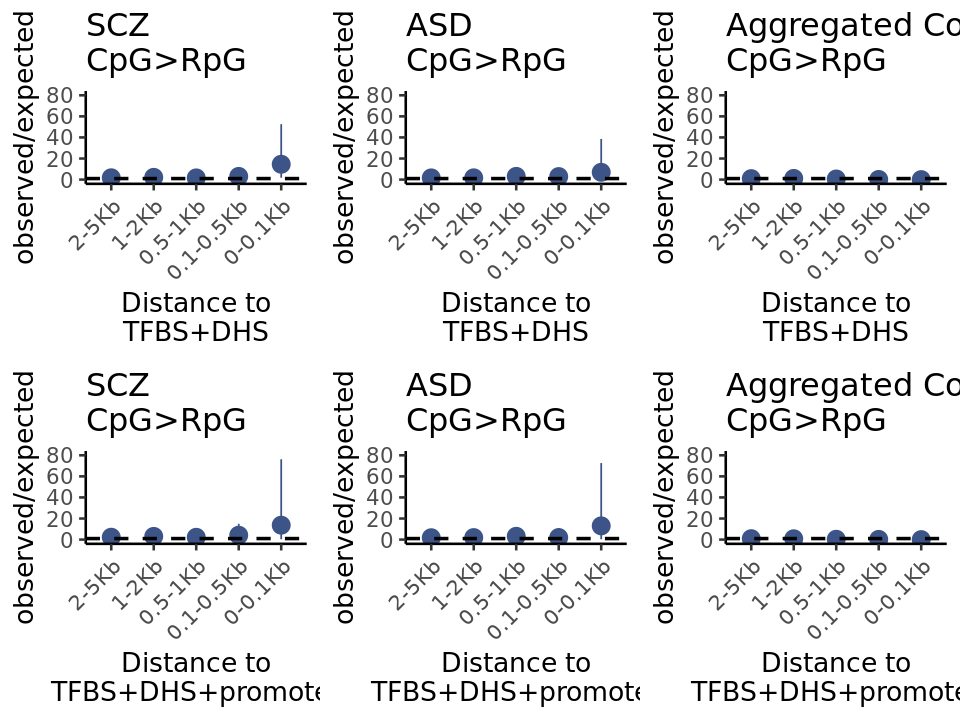

In [12]:
p1 = get_rate_cg(granges(v_scz), "SCZ\nCpG>RpG",in_tss = FALSE)
print(p1$stats_df)
p1 = p1$p
p2 = get_rate_cg(granges(v_scz), "SCZ\nCpG>RpG",in_tss = TRUE)
print(p2$stats_df)
p2=p2$p
p3 = get_rate_cg(granges(v_asd), "ASD\nCpG>RpG",in_tss=FALSE)
print(p3$stats_df)
p3=p3$p
p4 = get_rate_cg(granges(v_asd), "ASD\nCpG>RpG",in_tss=TRUE)
print(p4$stats_df)
p4 = p4$p
p5 = get_rate_cg(v_control_combined, "Aggregated Controls\nCpG>RpG", in_tss=FALSE)
print(p5$stats_df)
p5=p5$p
p6 = get_rate_cg(v_control_combined, "Aggregated Controls\nCpG>RpG", in_tss=TRUE)
print(p6$stats_df)
p6=p6$p

options(repr.plot.width=8, repr.plot.height=6)
pX = ggpubr::ggarrange(p1,p3,p5,p2,p4,p6, nrow=2,ncol=3)
pX

ggsave(pX, filename="../../figures/cpg_rpg_tfbs_all_no_outlier.pdf",device="pdf",height=6, width=8)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 192 Columns: 15
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: " "
chr  (2): comp.1, offset
dbl (13): comp.2, comp.3, comp.4, comp.5, comp.6, comp.7, comp.8, comp.9, co...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


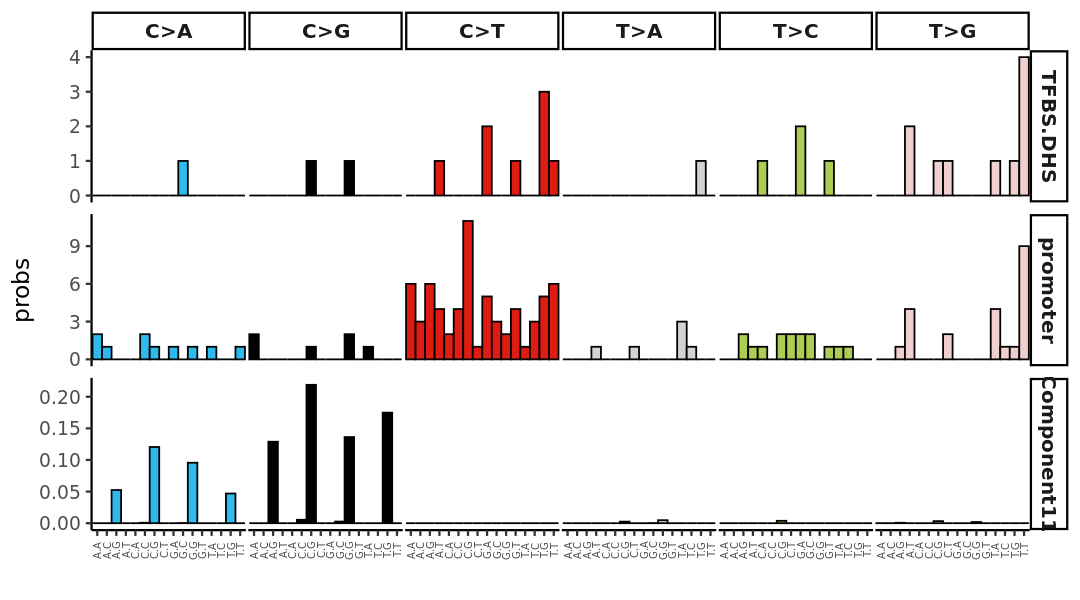

In [13]:
## Vova process
library(MutationalPatterns)
ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)

signatures = get_known_signatures()
epimark = rtracklayer::import("../../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")

epimark$ntile = ntile(epimark$score, 10)


epimark_top = epimark[epimark$ntile == 10]


v_scz_dhs = granges(v_scz) %>% filter_by_overlaps(epimark_top) %>% filter_by_overlaps(tf_final) 
genome(v_scz_dhs) = "hg19"

df = as.data.frame(transcript.gr)
# df$expr = median_pcw_tpm$value[match(df$ensembl_gene_id,median_pcw_tpm$gene)]
# df = df %>% mutate(ntile = ntile(expr,2)) %>% filter(ntile == 2)

tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                          end=df$transcription_start_site),
                strand=df$STRAND)

tss.gr = flank(tss.gr, width=2500 + width(tss.gr),start=TRUE)
#tss.gr = c(flank(tss.gr,10000, start=TRUE), flank(tss.gr, 10000, start=FALSE))

h = findOverlaps(v_scz,tss.gr)
v_scz_tss = v_scz[queryHits(h)]
genome(v_scz_tss) = "hg19"

vova_components = read_delim("../../resources/Vova_signatures.txt")
odd_bases = c("G>T","G>C","G>A","A>T","A>G","A>C")
comp = list("AA" = "TT", "AC" ="TG", "AG"="TC","AT"="TA",
           "CA" = "")
comp11 = vova_components %>% mutate(base_change = paste0(substr(comp.1,2,2),">",substr(comp.1,5,5))) %>%
    mutate(cnt = paste0(substr(comp.1,1,1),substr(comp.1,3,3)))
# comp11

comp11$rev_cnt = as.character(reverseComplement(DNAStringSet(comp11$cnt)))

odd_bases = c("G>T","G>C","G>A","A>T","A>G","A>C")
comp11 = comp11 %>%
    mutate(base_change2 = ifelse(base_change == "G>T","C>A",base_change)) %>%
    mutate(base_change2 = ifelse(base_change2 == "G>C","C>G",base_change2)) %>%
    mutate(base_change2 = ifelse(base_change2 == "G>A", "C>T",base_change2)) %>%
    mutate(base_change2 = ifelse(base_change2 == "A>T","T>A", base_change2)) %>%
    mutate(base_change2 = ifelse(base_change2 =="A>G","T>C", base_change2)) %>%
    mutate(base_change2 = ifelse(base_change2 == "A>C","T>G",base_change2)) %>%
    mutate(base_change2 = ifelse(base_change %in% odd_bases,
                                 paste0(substr(rev_cnt,1,1),"[",base_change2,"]",substr(rev_cnt,2,2)),
                                paste0(substr(cnt,1,1),"[",base_change2,"]",substr(cnt,2,2)))) %>%
    group_by(base_change2) %>% summarise(component_11 = sum(comp.12))



mut_mat_dhs = mut_matrix(v_scz_dhs, ref_genome=ref_genome)
mut_mat_tss = mut_matrix(granges(v_scz_tss), ref_genome=ref_genome)


mut_mat_scz = data.frame("TFBS.DHS"=mut_mat_dhs[,1], promoter=mut_mat_tss[,1],
                         tnc=rownames(mut_mat_dhs))

mut_mat_scz$Component11 = comp11$component_11[match(rownames(mut_mat_scz), comp11$base_change2)]

options(repr.plot.width=9, repr.plot.height=5)
p1 = mut_mat_scz %>% mutate(subs =rep(c("C>A","C>G","C>T","T>A","T>C","T>G"),each=16)) %>%
    pivot_longer(cols= c(-tnc,-subs), names_to="sigs", values_to ="probs") %>% 
    mutate(sigs = factor(sigs,levels=c("TFBS.DHS","promoter","Component11"))) %>%
                        ggplot(aes(x=tnc, y=probs)) + 
                        geom_bar(aes(fill=subs),color="black",stat="identity",width = 1, show.legend = FALSE) + 
                            facet_grid(sigs~subs, scales="free")+ 
                            theme_classic(14) + 
                            labs(x="") +
                            scale_fill_manual(values = c("#2EBAED", "#000000", "#DE1C14","#D4D2D2", "#ADCC54", "#F0D0CE")) +
                            theme(strip.text = element_text(size= 12, face="bold"), 
                                  axis.text.x = element_text(angle=90,vjust=0.5, size=6),
                                 panel.spacing.x = unit(0.1, "lines"),
                                 panel.grid = element_blank()) +
                            scale_x_discrete(labels= paste(substr(mut_mat_scz$tnc, 1, 1), substr(mut_mat_scz$tnc, 7, 7), sep = "."))
p1

ggsave(p1, filename = "../../figures/cpg_trinuc_context_no_outlier.pdf",device="pdf",width=9, height=5)

In [14]:
oe_func3 <- function(target_vcf,region,regionName, triRateTable, b,
                    surveyed=NULL,ref_genome = "BSgenome.Hsapiens.UCSC.hg19",cpg=FALSE){

    
    ## calculate observed and expected ratio
    n_muts = length(target_vcf)
    
    if(is.null(surveyed)){
        library(ref_genome, character.only = TRUE)
        gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19)[1:24]
        surveyed_length = sum(letterFrequency(gwide.seq,letters = c("C","G")))
    } else{
        gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19,surveyed)
        surveyed_length = sum(letterFrequency(gwide.seq,letters = c("C","G")))
    }

    if(is.null(surveyed)){
        surveyed_region = region
    } else{
        surveyed_region = surveyed %>% join_overlap_intersect(region)
    }
    
    reg_seqs = getSeq(BSgenome.Hsapiens.UCSC.hg19, surveyed_region)
    surveyed_region_length = sum(dinucleotideFrequency(reg_seqs)[,c("CG")])
    

    # Find which mutations lie in the surveyed genomic region
    extension = 1
    dinuc_context <- as.character(Biostrings::getSeq(
    BSgenome::getBSgenome(ref_genome),
    seqnames(target_vcf),
    start(target_vcf) - extension,
    end(target_vcf) + extension
    ))

    target_vcf$dn = dinuc_context
    plus_cg = c("ACG","CCG","GCG","TCG")
    neg_cg = c("CGA","CGC","CGG","CGT")
    
#     target_vcf = target_vcf %>% filter(!(dn %in% plus_cg | dn %in% neg_cg))
    
    target_vcf = target_vcf[ (target_vcf$REF == "C" & as.character(unlist(target_vcf$ALT)) == "G" & target_vcf$dn %in% plus_cg) | 
                  (target_vcf$REF == "G" & as.character(unlist(target_vcf$ALT)) =="C" & target_vcf$dn %in% neg_cg) |
                           (target_vcf$REF =="C" & as.character(unlist(target_vcf$ALT)) == "A" & target_vcf$dn %in% plus_cg) |
                           (target_vcf$REF == "G" & as.character(unlist(target_vcf$ALT))== "T" & target_vcf$dn %in% neg_cg)]
    
    triRateTable = get_triRate(target_vcf = target_vcf)
    
    
    
    muts_in_region = target_vcf %>% filter_by_overlaps(surveyed_region)
    print(muts_in_region)
    observed = sum(countOverlaps(surveyed_region, target_vcf))

    #Add base to start and end to get correct trinuc counts
    surveyed_region@ranges@start <- as.integer(surveyed_region@ranges@start - 1)
    surveyed_region@ranges@width <- as.integer(surveyed_region@ranges@width + 2)
    
    #Count trinuc freq
    sequences = getSeq(BSgenome.Hsapiens.UCSC.hg19, surveyed_region)
    tri_freqs <- trinucleotideFrequency(sequences)

    complement = vector()
    complement["A"] = "T"; complement["C"] = "G"; complement["G"] = "C"; complement["T"] = "A";	
    tri_freqs_summary <- as_tibble(tri_freqs) %>% 
        dplyr::summarise(across(.cols = everything(), sum)) %>% 
        pivot_longer(cols = everything(), names_to = "context0", values_to = "count") %>% 
        #Convert to pyr reference
        mutate(context = ifelse(str_sub(context0,2,2) %in% c("C", "T"), context0, paste0(complement[str_sub(context0, 3,3)], complement[str_sub(context0, 2,2)], complement[str_sub(context0, 1,1)]))) %>% 
        group_by(context) %>% 
        dplyr::summarise(count = sum(count), .groups = "drop") %>% 
        left_join((triRateTable), by = "context") %>% 
        mutate(expected = count * (rate))
    
    if(cpg){
        tri_freqs_summary = tri_freqs_summary %>% filter(substr(context,2,3) == "CG")
    } else{
        tri_freqs_summary = tri_freqs_summary %>% filter(substr(context,2,3) != "CG") %>%
            filter(substr(context,2,2) == "C")
    }

    expected = sum(tri_freqs_summary$expected)
    
    ## calculate CIs
#     n_sims = 10000
#     observations = replicate(n_sims, 
#                              sum(countOverlaps(target_vcf[sort(sample(length(target_vcf), size=length(target_vcf), 
#                                                                       replace=TRUE))],surveyed_region)))
#     cis <- quantile(observations, probs = c(0.025, 0.975))
    
    tmp = poisson.test(c(observed,surveyed_region_length),c(expected, surveyed_region_length))
#     pval = sum(observations/expected <1)/n_sims
    pval = tmp$p.value
    cis = tmp$conf.int
    
    res = data.frame(n_muts,
                surveyed_length,
                regionName,
                surveyed_region_length,
                expected,
                observed,
                     oe = observed/expected,
                    low_ci= cis[1],
                    high_ci = cis[2], pval = pval)
    return(res)

}

In [15]:
## CpG Island analysis
cpg_islands = rtracklayer::import("../../resources//CpgG_islands.bed",format="BED")  %>% 
    reduce_ranges() %>% 
    filter(seqnames %in% c(paste0("chr",1:22),"chrX","chrY"))
genome(cpg_islands) = "hg19"

asd_vcf  = granges(v_asd)
genome(asd_vcf) = "hg19"



cpg_scz = oe_func3(target_vcf = scz_vcf,region = cpg_islands,regionName ="SCZ", cpg=TRUE)
cpg_control = oe_func3(target_vcf = v_control_combined, region=cpg_islands, regionName="combined-controls",cpg=TRUE)
cpg_asd = oe_func3(target_vcf =asd_vcf , region=cpg_islands, regionName="ASD",cpg=TRUE)


GRanges object with 1 range and 7 metadata columns:
      seqnames    ranges strand |            X       VAF            REF
         <Rle> <IRanges>  <Rle> |  <character> <numeric> <DNAStringSet>
  [1]     chr3 150321366      * | CMC_PITT_118  0.168067              G
                     ALT      QUAL      FILTER          dn
      <DNAStringSetList> <numeric> <character> <character>
  [1]                  C        NA        <NA>         CGG
  -------
  seqinfo: 24 sequences from hg19 genome; no seqlengths
GRanges object with 25 ranges and 7 metadata columns:
       seqnames    ranges strand |            X       VAF            REF
          <Rle> <IRanges>  <Rle> |  <character> <numeric> <DNAStringSet>
   [1]     chr4  55099655      * | CMC_MSSM_100 0.0110375              C
   [2]    chr11   9025360      * | CMC_MSSM_227 0.1224490              G
   [3]     chr7 155259778      * | CMC_MSSM_406 0.0179641              C
   [4]     chr8 145025128      * | CMC_MSSM_406 0.0176600             

n_muts,surveyed_length,regionName,surveyed_region_length,expected,observed,oe,low_ci,high_ci,pval
<int>,<int>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2236,1170371008,SCZ,2089538,3.235873,1,0.3090356,0.007824099,1.721838,0.3923833
21211,1170371008,combined-controls,2089538,30.454364,25,0.8209004,0.531242219,1.211814,0.3647477
1702,1170371008,ASD,2089538,3.394129,3,0.8838792,0.182276983,2.583074,1.0000000


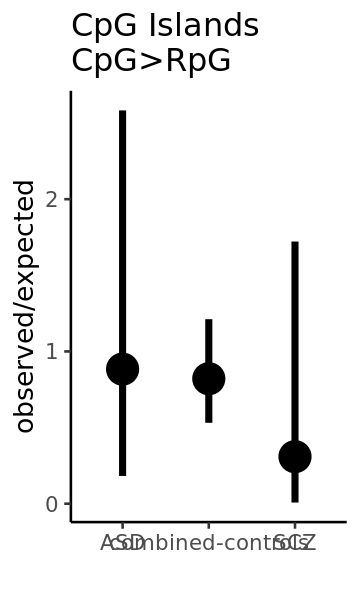

In [16]:
plot_df = rbind(cpg_scz,cpg_control,cpg_asd)
plot_df 


options(repr.plot.width=3, repr.plot.height=5)
p1=plot_df %>% ggplot(aes(x=regionName,y=oe)) + 
    geom_pointrange(aes(ymax=high_ci,ymin=low_ci), size=2,fill="black", pch=21, lwd=2) +
    theme_classic(16) +
    labs(y="observed/expected",x="",title="CpG Islands\nCpG>RpG")
p1
ggsave(filename = "../../figures/cpg_island_plot_no_outlier.pdf",plot = p1, device="pdf",width=3,height=5)
    

In [17]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/app/openblas/0.3.19-gcc-9.2.0/lib/libopenblas_haswellp-r0.3.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] liftOver_1.22.0                        
 [2] Homo.sapiens_1.3.1                     
 [3] TxDb.Hsapiens.UCSC.hg19.knownGene_3.2.2
 [4] org.Hs.eg.db_3.16.0                    
 [5] GO.db_3.16.0                           
 [6] OrganismDbi_1.40.0                     
 [7] 